In [1]:
import numpy as np
import pickle
import copy

from scipy.stats import linregress

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
avg_window=10

In [4]:
dirname='/global/homes/a/abbatej/'
with open(dirname+'final_data.pkl', 'rb') as f: 
    raw_data=pickle.load(f, encoding='latin1')

In [5]:
# average over the previous avg_window timesteps 
def smooth_signal(sig, avg_window):
    #do nothing:
    #return np.array(sig)
    
    #actually smooth:
    return np.array([np.mean(sig[ind-avg_window:ind],axis=0) for ind in range(avg_window, len(sig))])

    # for getting the full mean over rho points
    #return np.array([np.mean(sig[ind-avg_window:ind]) for ind in range(avg_offset, len(sig))])

In [6]:
num_train_shots=700
num_val_shots=200

shots = sorted(raw_data.keys())

# specify the signals we want
sigs_1d = sorted(['e_temp','e_dens'])
sigs_0d = sorted(['curr_target','tinj', 'pinj', 'gasA'])#, 'gasA'])
sigs = sigs_0d+sigs_1d

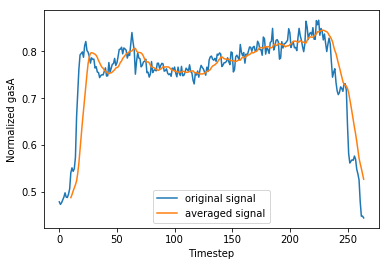

In [7]:
sig=np.mean(raw_data[shots[0]]['e_temp'],axis=1)

new_data=smooth_signal(sig, avg_window)
plt.plot(sig, label='original signal')
plt.plot(list(range(avg_window,len(sig))),new_data,label='averaged signal')
plt.xlabel('Timestep')
plt.ylabel('Normalized gasA')
plt.legend()
plt.show()

In [8]:
# first get the indices that contain all the data we need
# (both train and validation)
train_shots=[]
val_shots=[]
for shot in shots:
    if set(sigs).issubset(raw_data[shot].keys()):         
        if (len(train_shots)<num_train_shots):
            train_shots.append(shot)
        elif (len(val_shots)<num_val_shots):
            val_shots.append(shot)
        else:
            break

In [9]:
# smooth each signal
data={}
for shot in (train_shots+val_shots):
    data[shot]={}
    for sig in sigs_0d:
        data[shot][sig] = smooth_signal(raw_data[shot][sig],avg_window)
    for sig in sigs_1d:
        data[shot][sig] = smooth_signal(raw_data[shot][sig],avg_window)

In [10]:
count=0
for shot in (train_shots+val_shots):
    if data[shot]['e_temp'].size==0:
        count+=1
        data.pop(shot,None)
        if shot in train_shots:
            train_shots.remove(shot)
        if shot in val_shots:
            val_shots.remove(shot)
print('Removed {} shots with empty arrays'.format(count))

Removed 15 shots with empty arrays


In [11]:
for shot in data:
    for sig in sigs_1d:
        data[shot]['{}_mean'.format(sig)] = np.mean(data[shot][sig],axis=1)

In [12]:
means={}
stds={}

shots=train_shots
for sig in data[shots[0]]:
    means[sig] = np.nanmean(np.array([np.nanmean(data[shot][sig], axis=0) for shot in shots]),axis=0)
    stds[sig] = np.nanstd(np.array([np.nanmean(data[shot][sig],axis=0) for shot in shots]),axis=0)

In [13]:
def normalize(obj, sig):
    mean=means[sig]
    std=stds[sig]
    return (obj-mean)/std

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

Shot: 163834


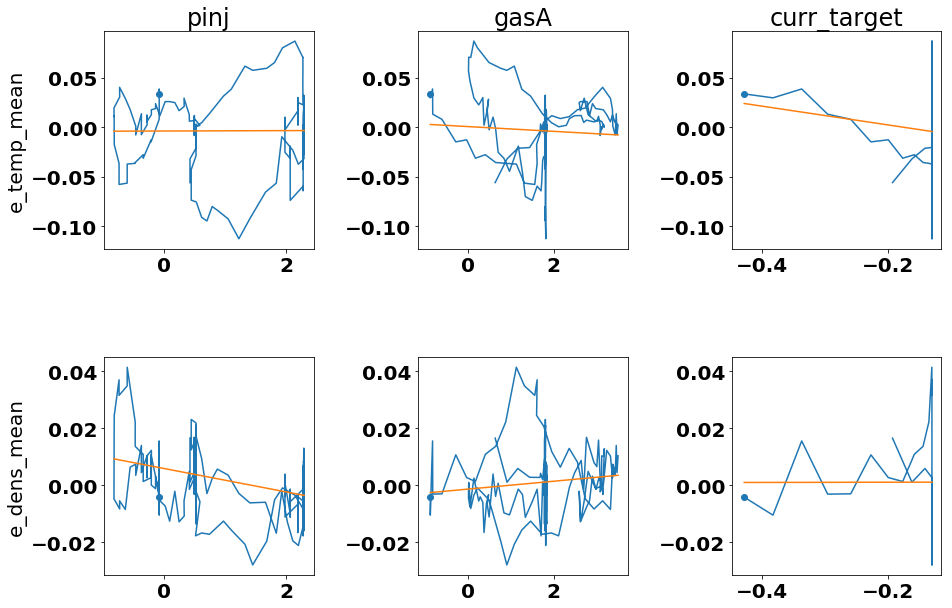

In [15]:
shots=val_shots
shot= shots[np.random.randint(len(shots))]
print('Shot: {}'.format(shot))

fig=plt.figure()
ind_sigs=['pinj','gasA','curr_target']
dep_sigs=['e_temp_mean','e_dens_mean']

for j,dep_sig in enumerate(dep_sigs):
    for i,ind_sig in enumerate(ind_sigs):
        ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))
        if i==0:
            ax.set_ylabel(dep_sig)
        if j==0:
            ax.set_title(ind_sig)

        #ax.set_xlim(-2,2)
        #ax.set_ylim(-2,2)
        x=normalize(data[shot][ind_sig],ind_sig)[:-1]
        y=np.diff(normalize(data[shot][dep_sig],dep_sig))
        ax.plot(x,y)
        ax.scatter(x[0],y[0])
        
        slope, intercept, r_value, p_value, std_err = linregress(x,y)
        base_x=np.linspace(min(x),max(x),5)
        ax.plot(base_x,base_x*slope+intercept)
        
plt.subplots_adjust(hspace=.5)
plt.subplots_adjust(wspace=.5)

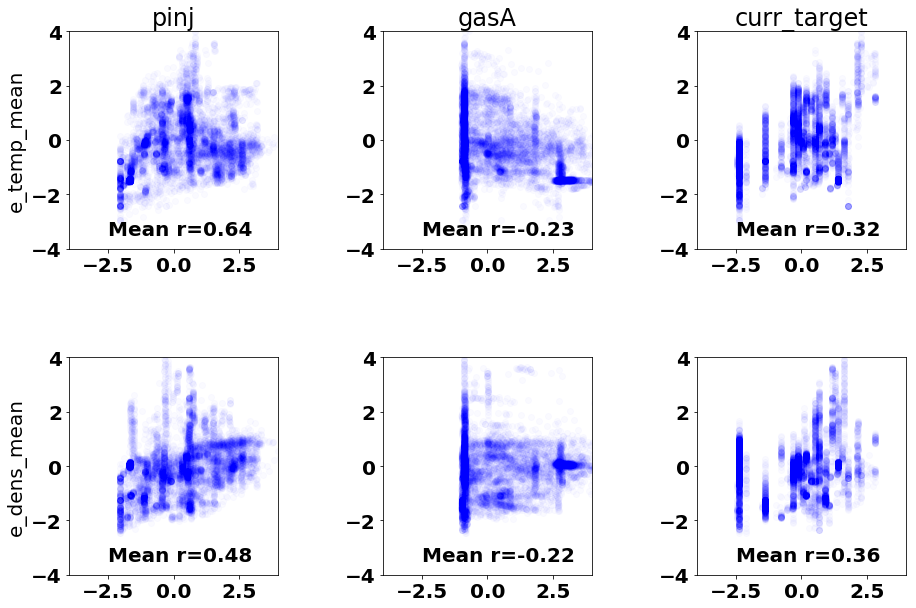

In [20]:
fig=plt.figure()
ind_sigs=['pinj','gasA','curr_target']
dep_sigs=['e_temp_mean','e_dens_mean']
offset=5

shots=val_shots
r_values=np.zeros((len(ind_sigs),len(dep_sigs),len(shots)))
for k,shot in enumerate(shots):
    for j,dep_sig in enumerate(dep_sigs):
        for i,ind_sig in enumerate(ind_sigs):
            ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))

            x=normalize(data[shot][ind_sig],ind_sig)[:-offset:5]
            y=normalize(data[shot][dep_sig],dep_sig)[offset::5]
            if y.size==0: 
                continue
                
            ax.scatter(x,y,color='b',alpha=.02)
            
            slope, intercept, r_value, p_value, std_err = linregress(x,y)
            #base_x=np.linspace(min(x),max(x),5)
            #ax.plot(base_x,base_x*slope+intercept,alpha=1,c='b')
            r_values[i][j][k]=r_value
            
for j,dep_sig in enumerate(dep_sigs):
    for i,ind_sig in enumerate(ind_sigs):
        ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))
        
        if i==0:
            ax.set_ylabel(dep_sig)
        if j==0:
            ax.set_title(ind_sig)

        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)
        
        ax.text(-2.5,-3.5,'Mean r={0:.2f}'.format(np.mean(r_values[i][j][:])))
            
        
plt.subplots_adjust(hspace=.5)
plt.subplots_adjust(wspace=.5)

In [35]:
ind_sigs=['pinj','gasA','curr_target']
dep_sigs=['e_temp_mean','e_dens_mean']
offsets=np.arange(1,30)

shots=val_shots

r_values=np.zeros((len(offsets),len(ind_sigs),len(dep_sigs),len(shots)))

for l,offset in enumerate(offsets):
    for k,shot in enumerate(shots):
        for j,dep_sig in enumerate(dep_sigs):
            for i,ind_sig in enumerate(ind_sigs):
                x=normalize(data[shot][ind_sig],ind_sig)[:-offset:5]
                y=normalize(data[shot][dep_sig],dep_sig)[offset::5]
                if y.size==0: 
                    continue

                slope, intercept, r_value, p_value, std_err = linregress(x,y)
                r_values[l][i][j][k]=r_value

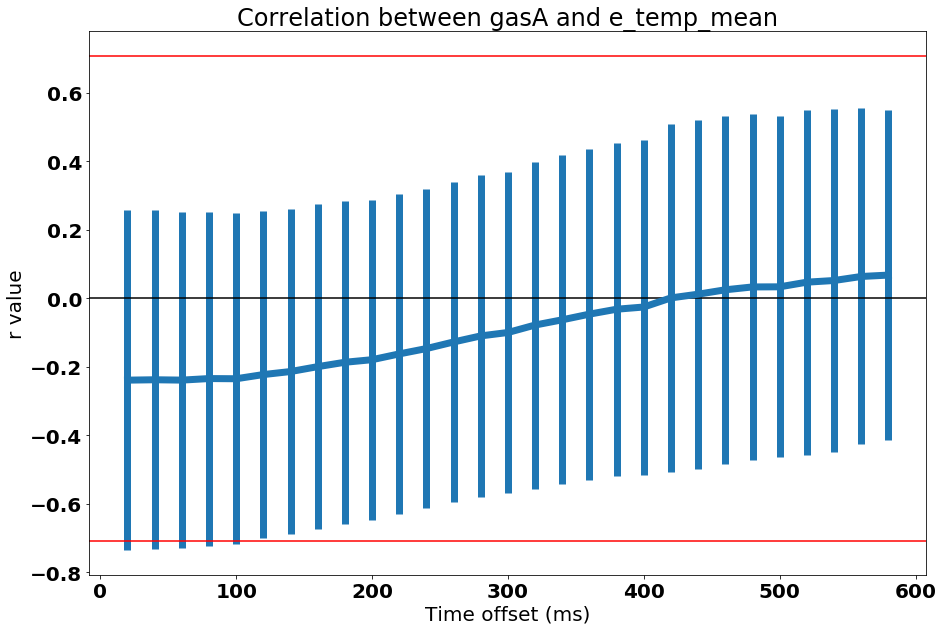

In [64]:
correlation=[]
dev=[]
ind_index=1
dep_index=0

for l in range(len(offsets)):
    correlation.append(np.mean(r_values[l][ind_index][dep_index][:])) #offset, dep, ind, example
    dev.append(np.std(r_values[l][ind_index][dep_index][:]))

plt.figure()
plt.errorbar(offsets*20,correlation,yerr=dev,linewidth=7)
plt.title('Correlation between {} and {}'.format(ind_sigs[ind_index],dep_sigs[dep_index]))
plt.xlabel('Time offset (ms)')
plt.ylabel('r value')
plt.axhline(np.sqrt(.5),color='r')
plt.axhline(-np.sqrt(.5),color='r')
plt.axhline(0,color='k')
plt.show()

Shot: 163833


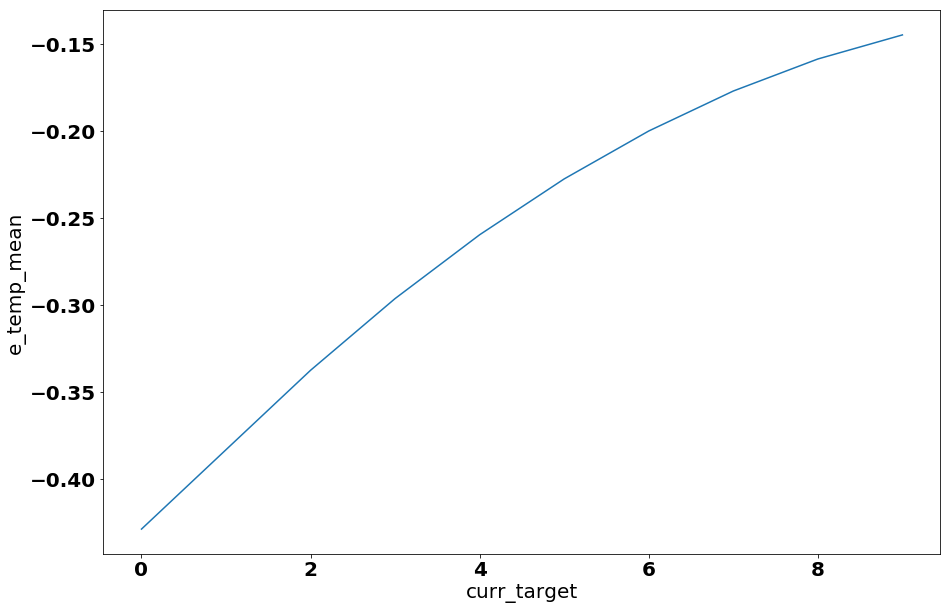

In [153]:
shots=val_shots
shot= shots[np.random.randint(len(shots))]
print('Shot: {}'.format(shot))

fig=plt.figure()
ind_sigs=['pinj','gasA','curr_target']
dep_sigs=['e_temp_mean','e_dens_mean']

ind_sig=ind_sigs[2]
dep_sig=dep_sigs[0]

ax=fig.add_subplot(111)
ax.set_ylabel(dep_sig)
ax.set_xlabel(ind_sig)
# x=normalize(data[shot][ind_sig],ind_sig)
# y=normalize(data[shot][dep_sig],dep_sig)
y=normalize(data[shot][ind_sig],ind_sig)[:10]

# ax.plot(x,y)
# ax.scatter(x[0],y[0])
ax.plot(y)

# slope, intercept, r_value, p_value, std_err = linregress(x,y)
# base_x=np.linspace(min(x),max(x),5)
# ax.plot(base_x,base_x*slope+intercept)
plt.show()